# Data Analysis 

This notebook contains the data analysis steps to evaluate *Drosophila* data using the MARS tools.

All analysis is done in python3.

## Required modules and tools
#### From conda:
* ipython==4.2.0
* jupyter==1.0.0
* numpy==1.10.4
* pandas==0.17.1
* scipy==0.16.0
* seaborn==0.5.1
* matplotlib==1.4.3

#### From Bioconda
* gimmemotifs==0.8.5
* pybedtools==0.8.1

#### Non-python modules

* meme v4.11.1
* bedtools v2.24.0

# 1. Summary stats

Summarize the motif table to find transcription factors that have more than 10 motifs

Select the TFS that have  more than 10 motifs

In [1]:
#Set up the required directories
! [ ! -d Data ] && mkdir Data
! [ ! -d Results ] && mkdir Results
! [ ! -d Figures ] && mkdir Figures

In [1]:
# Import all the dependacies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
from scipy.stats.mstats import winsorize
import scipy.stats
import numpy as np
from math import log
from scipy import stats
#import os moduls
import os
import glob

## Bioconda
import pybedtools

# MAke graphs appear in the notebook
%matplotlib inline

In [3]:
# Set global variables
# path to your genome
dm6 = "../genome/dm6.fa"

In [4]:
## Read the motifs data file
motif_table = pd.read_csv("../db-tables/dm-motif.tsv", sep = "\t", header = None)

# Get a snippet of the data
motif_table.head()
# Get info about your data
motif_table.info()
# Show structure of your data
motif_table.shape
# Set up column names
motif_table.columns = ["id", "motif_name", "Tf_name", "Collection_db", "Tf_id" ]
motif_table.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295 entries, 0 to 2294
Data columns (total 5 columns):
0    2295 non-null int64
1    2295 non-null object
2    2295 non-null object
3    2295 non-null object
4    2133 non-null object
dtypes: int64(1), object(4)
memory usage: 89.8+ KB


Index(['id', 'motif_name', 'Tf_name', 'Collection_db', 'Tf_id'], dtype='object')

In [5]:
# Summarize the TF ID column to get counts of motifs
#Check for null values in each column
#motif_table.isnull().sum()
# Drop null values as they are uncategorized motifs with no TF class
motif_table = motif_table.dropna()
motif_table.isnull().sum()

id               0
motif_name       0
Tf_name          0
Collection_db    0
Tf_id            0
dtype: int64

In [14]:
# Describe the TF id representation
motif_table['Tf_id'].describe()

# Get the counts of each representation
counts = motif_table['Tf_id'].value_counts().rename_axis('Tf_id').to_frame('counts') # Tf_id becomes the index
counts = motif_table['Tf_id'].value_counts().rename_axis('Tf_id').reset_index(name='counts')

# Get TF with over 10 motifs
over10motifs = counts[counts['counts'] >= 10]
over10motifs.shape

(56, 2)

In [15]:
#Get the TF table to extract tf names and join to the over 10 motifs
tf_table = pd.read_csv("../db-tables/Drosophila-TFs.tsv", sep = "\t", header = None)
tf_table.columns = ["Tf_id", "tf_name", "alt_name", "Tf_family" ]
tf_table =tf_table[["Tf_id", "tf_name"]]
# Chenge the int64 type to string in Tf_id
tf_table['Tf_id'] = tf_table.Tf_id.astype('str')

# Merge the file
over10motifs = pd.merge(over10motifs, tf_table, how = 'inner', left_on = ['Tf_id'], right_on = ['Tf_id'])
#Swap columns around
over10motifs = over10motifs.reindex(columns=["Tf_id", "tf_name", "counts"])
over10motifs

,Tf_id,tf_name,counts
0,283,lola,46
1,13,da,32
2,513,brk,31
3,89,br,20
4,56,tgo,19
5,428,bcd,18
6,430,cad,17
7,471,ems,17
8,343,ttk,17
9,426,Abd-B,16


In [16]:
# select a tf to work on
# we will work on bcd
tf = 'lola'

# select the different tf names used on the different databases to a list
## Get the id of the tf name
idtf = over10motifs[over10motifs["tf_name"] == tf]
idtf = idtf ["Tf_id"].values[0]

# Get the motif names in the various data bases
get = motif_table[motif_table["Tf_id"] == idtf]
# Put the names in a list and retain the unique ones
motlist = get["Tf_name"].tolist()
motlist = list(set(motlist))
motlist

['lola-PC',
 'lola-PQ',
 'lola-PG',
 'lola-PF',
 'lola-PU',
 'lola-PD',
 'lola',
 'lola-PA',
 'lola-PL',
 'lola-PO',
 'lola-PT',
 'lola-PW',
 'lola-PY',
 'lola-PJ',
 'lola-PK']

In [17]:
# Define functions
def extract_meme_list(meme_in, out_meme, mot_list):
    """
    Use this to extract motifs in a given list from the main file. This differes
    from extract_scored since it does not add the scores of the motifs to the 
    meme header name
    """
    meme_head = """MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n
Background letter frequencies (from uniform background):
A 0.25000 C 0.25000 G 0.25000 T 0.25000\n"""
    with open(out_meme, "w") as meme_out:
        meme_out.write(meme_head)
    for mot in mot_list:
        extract_meme_clean(meme_in, mot, out_meme)

def extract_meme_clean(meme_in, motif, meme_out):
    """
    Get the given motif from a meme file and writes to a meme file but without a meme heading
    """
    with open(meme_in) as f1:
        with open(meme_out, "a") as out_meme:
            lines = f1.readlines()
            for i, line in enumerate(lines):
                head = line.split()
                
                if motif in line:
                    # Sanity check
                    tag = False
                    if len(head) == 2 and motif == head[1]:
                        tag = True
                    if len(head) == 3 and motif == head[2]:
                        tag = True
                    if tag:
                        k = i
                        out_meme.write("\n"+lines[i].strip()+"\n\n")
                        if "log-odds" in lines[i+1]:
                            odds = lines[k+2].split()
                            for j in range(2, (int(odds[5])+3)*2):
                                out_meme.write(lines[i+j]),
                        elif "letter-probability" in lines[i+2]:
                            out_meme.write(lines[i+2])
                            odds = lines[k+2].split()
                            for j in range(0, (int(odds[5]))):
                                out_meme.write(lines[i+3+j])
                        elif "letter-probability" in lines[i+1]:
                            out_meme.write(lines[i+1])
                            odds = lines[k+1].split()
                            for j in range(0, (int(odds[5]))):
                                out_meme.write(lines[i+2+j])
                        else:
                            pass
                    else:
                        pass

In [18]:
# Get the meme file for the tf
meme_in = "Data/all_dm_motifs.meme"
out_meme = "Results/" + tf + ".meme"
motlist = motlist
extract_meme_list(meme_in, out_meme, motlist)

## CB-MAR: Tomtom demonstration

This section demonstrates the implementation of CB-MAR

### 1. First run tomtom pairwise comparison

We use bcd to demonstrate how the analysis is carried out.
The _**bcd.meme**_ file which we extracted above is in the **Results** directory.


In [19]:
## Ensure tomtom is in your path

meme_in = "Results/" + tf +".meme"
results_folder = "Results"
tf = tf
os.system(
    "tomtom -min-overlap 1 -dist %s -evalue -text -thresh 1000 -verbosity 1 %s %s >%s/%s_tomtom.txt" %
          ("ed", meme_in, meme_in, results_folder, tf))
# Remove the extra comment lines at the bottom when using meme v 5.1.1
f = open(results_folder+"/"+tf+"_tomtom.txt", "r")
tmp = f.readlines()

# Removee the last few lines which give the meme version and tom tom command used
with open(results_folder+"/"+tf+"_tomtom.txt", "w") as f:
    for line in tmp:
        if line.startswith("#"):
            continue
        else:
            f.write(line)

# Clean up the data and process it

In [20]:
infile = "Results/" + tf +"_tomtom.txt"
tomtom = pd.read_csv(infile,sep='\t')

# To avoid zezo division, use add the smallest possible value to each

tomtom["p-value"] += 0.000000000000000000000000000000000000000000000001

#Get the negative log of the p-value column
tomtom["p-value"] = -tomtom["p-value"].apply(log)

#Exatract the important columns to be used for any further analysis
tomtom = tomtom[["Query_ID", "Target_ID", "p-value"]]
#print(tomtom)
#Change the column names
## DO NOT USE this tomtom.columns = [["Query_ID", "Target_ID", "Score"]]
## When renaming columns, use DataFrame.columns = [list], not DataFrame.columns = [[list]]:
tomtom.columns = ["Query_ID", "Target_ID", "Score"]

#Piv0t the data into a pairwise matrix
#print (tomtom)
tomtom_matrix = tomtom.pivot(index="Query_ID", columns="Target_ID", values="Score")
tomtom_matrix

Target_ID,M06091_2.00,M06092_2.00,M06093_2.00,M06094_2.00,M06095_2.00,M06096_2.00,M06097_2.00,M06098_2.00,M06099_2.00,M06100_2.00,...,lola-PT_SOLEXA_FBgn0005630,lola-PU_SANGER_5_FBgn0005630,lola-PU_SOLEXA_FBgn0005630,lola-PW_SANGER_5_FBgn0005630,lola-PW_SOLEXA_FBgn0005630,lola-PY_SANGER_2.5_FBgn0005630,lola-PY_SOLEXA_FBgn0005630,lola_PK_SANGER_5_FBgn0005630,lola_SANGER_5_FBgn0005630,lola_SOLEXA_5_FBgn0005630
Query_ID,,,,,,,,,,,,,,,,,,,,,
M06091_2.00,34.782195,2.924638,1.019980,2.997824,1.788708,0.760953,2.021225,0.613447,0.518975,3.746411,...,0.115913,0.037340,0.052469,0.062957,0.009928,6.399511,4.563357,1.772098,1.331878,2.098665
M06092_2.00,2.599233,47.475432,0.192464,1.125057,1.110055,1.146937,0.373138,1.375560,0.249807,1.493884,...,0.657537,0.539491,1.000893,0.396292,0.681343,0.052557,0.059541,0.334872,1.461742,2.467206
M06093_2.00,0.915673,0.133122,49.427275,1.404385,0.083460,0.000791,2.085886,3.022662,3.956748,0.168206,...,0.514143,1.166883,0.794779,0.044301,0.298366,0.991443,3.645590,1.731363,0.008402,0.005148
M06094_2.00,2.950853,2.431256,1.118028,51.591755,3.268951,0.272505,2.946885,1.808218,0.072309,2.966745,...,2.056006,1.295774,2.090470,0.925251,2.000098,2.201049,2.473148,2.555076,1.978771,2.066944
M06095_2.00,2.071878,2.426311,0.007216,2.769016,31.856441,3.009511,1.231269,0.258273,0.771174,0.398481,...,2.499162,1.618479,2.694892,0.061592,0.365047,1.705085,1.188477,1.349515,10.824037,10.303559
M06096_2.00,0.427504,0.754516,0.030363,0.287641,1.956042,28.375201,1.770887,0.216588,0.167554,1.519579,...,0.855353,1.324387,0.972081,1.149352,0.540440,1.212267,0.443954,1.685207,0.667175,0.754516
M06097_2.00,1.076339,0.084117,1.605899,2.169865,0.301592,1.237954,63.590687,2.435858,0.945704,1.184893,...,0.286390,0.132783,0.525337,0.107848,1.224601,0.425667,2.402083,46.057821,0.000742,0.169664
M06098_2.00,0.525895,0.389465,2.339784,1.593958,0.135038,0.076758,2.404061,46.673085,1.513728,1.516089,...,0.809757,0.949129,0.741193,0.038551,0.482169,0.389465,1.194214,2.063852,0.000536,0.002476
M06099_2.00,0.530551,0.123013,4.341683,0.148500,1.222942,0.043243,1.219493,1.661442,40.432661,0.209606,...,1.719097,2.319823,2.100428,0.193400,0.515299,1.618060,1.051303,0.797084,0.272227,0.368100


### Reduce effect of extreme outliers by winzorizing the data

In [21]:
#convert the dataframe to an array the winsorize and finally convert back into a dataframe

tomtom_winz = pd.DataFrame(scipy.stats.mstats.winsorize(np.array(tomtom_matrix.values.T.tolist()),
                                                     limits=0.05), index=tomtom_matrix.index, columns=tomtom_matrix.columns)

tomtom_winz

Target_ID,M06091_2.00,M06092_2.00,M06093_2.00,M06094_2.00,M06095_2.00,M06096_2.00,M06097_2.00,M06098_2.00,M06099_2.00,M06100_2.00,...,lola-PT_SOLEXA_FBgn0005630,lola-PU_SANGER_5_FBgn0005630,lola-PU_SOLEXA_FBgn0005630,lola-PW_SANGER_5_FBgn0005630,lola-PW_SOLEXA_FBgn0005630,lola-PY_SANGER_2.5_FBgn0005630,lola-PY_SOLEXA_FBgn0005630,lola_PK_SANGER_5_FBgn0005630,lola_SANGER_5_FBgn0005630,lola_SOLEXA_5_FBgn0005630
Query_ID,,,,,,,,,,,,,,,,,,,,,
M06091_2.00,17.420759,2.599233,0.915673,2.950853,2.071878,0.427504,1.076339,0.525895,0.530551,3.501799,...,0.142848,0.059033,0.244067,0.188417,0.026950,7.327782,5.151602,1.061048,2.628706,3.076162
M06092_2.00,2.924638,17.420759,0.133122,2.431256,2.426311,0.754516,0.084117,0.389465,0.123013,1.265511,...,0.223682,0.312327,0.390878,0.456601,0.296138,0.658131,0.070020,0.155436,3.227556,2.923315
M06093_2.00,1.019980,0.192464,17.420759,1.118028,0.026950,0.030363,1.605899,2.339784,4.341683,0.194791,...,0.837341,2.512117,1.046123,0.081219,0.313915,0.894038,2.514686,1.487534,0.026950,0.026950
M06094_2.00,2.997824,1.125057,1.404385,17.420759,2.769016,0.287641,2.169865,1.593958,0.148500,2.571076,...,2.282577,1.998304,2.257306,0.857411,1.733030,2.165618,2.117991,2.172110,2.233516,2.689821
M06095_2.00,1.788708,1.110055,0.083460,3.268951,17.420759,1.956042,0.301592,0.135038,1.222942,0.271565,...,2.577924,2.923959,2.736462,0.288071,0.080293,1.702617,1.561920,0.432927,9.171591,9.408396
M06096_2.00,0.760953,1.146937,0.026950,0.272505,3.009511,17.420759,1.237954,0.076758,0.043243,1.723929,...,1.499602,2.201844,1.479300,1.299669,0.637892,0.692915,0.443242,1.429523,1.651761,0.964282
M06097_2.00,2.021225,0.373138,2.085886,2.946885,1.231269,1.770887,17.420759,2.404061,1.219493,1.219032,...,0.848317,0.535837,1.068539,0.455746,1.791643,0.863966,2.408748,17.420759,0.268688,0.956813
M06098_2.00,0.613447,1.375560,3.022662,1.808218,0.258273,0.216588,2.435858,17.420759,1.661442,1.308234,...,1.389796,1.670617,1.149513,0.505130,0.575446,0.689512,1.137240,2.435454,0.094200,0.238553
M06099_2.00,0.518975,0.249807,3.956748,0.072309,0.771174,0.167554,0.945704,1.513728,17.420759,0.093824,...,2.675315,2.948139,2.939027,0.735047,0.569202,1.587246,1.426483,0.896079,0.284631,0.554226


### Normalize the data by the maximum value

In [22]:
tomtom_normalized = tomtom_winz.div(tomtom_winz.max())
tomtom_normalized

Target_ID,M06091_2.00,M06092_2.00,M06093_2.00,M06094_2.00,M06095_2.00,M06096_2.00,M06097_2.00,M06098_2.00,M06099_2.00,M06100_2.00,...,lola-PT_SOLEXA_FBgn0005630,lola-PU_SANGER_5_FBgn0005630,lola-PU_SOLEXA_FBgn0005630,lola-PW_SANGER_5_FBgn0005630,lola-PW_SOLEXA_FBgn0005630,lola-PY_SANGER_2.5_FBgn0005630,lola-PY_SOLEXA_FBgn0005630,lola_PK_SANGER_5_FBgn0005630,lola_SANGER_5_FBgn0005630,lola_SOLEXA_5_FBgn0005630
Query_ID,,,,,,,,,,,,,,,,,,,,,
M06091_2.00,1.000000,0.149203,0.052562,0.169387,0.118932,0.024540,0.061785,0.030188,0.030455,0.201013,...,0.008200,0.003389,0.014010,0.010816,0.001547,0.420635,0.295716,0.060907,0.150895,0.176580
M06092_2.00,0.167882,1.000000,0.007642,0.139561,0.139277,0.043311,0.004829,0.022356,0.007061,0.072644,...,0.012840,0.017928,0.022437,0.026210,0.016999,0.037779,0.004019,0.008922,0.185271,0.167806
M06093_2.00,0.058550,0.011048,1.000000,0.064178,0.001547,0.001743,0.092183,0.134310,0.249225,0.011182,...,0.048066,0.144202,0.060050,0.004662,0.018020,0.051320,0.144350,0.085389,0.001547,0.001547
M06094_2.00,0.172083,0.064581,0.080616,1.000000,0.158949,0.016511,0.124556,0.091498,0.008524,0.147587,...,0.131026,0.114708,0.129576,0.049218,0.099481,0.124313,0.121579,0.124685,0.128210,0.154403
M06095_2.00,0.102677,0.063720,0.004791,0.187647,1.000000,0.112282,0.017312,0.007752,0.070200,0.015589,...,0.147980,0.167843,0.157081,0.016536,0.004609,0.097735,0.089659,0.024851,0.526475,0.540068
M06096_2.00,0.043681,0.065837,0.001547,0.015643,0.172754,1.000000,0.071062,0.004406,0.002482,0.098958,...,0.086081,0.126392,0.084916,0.074605,0.036617,0.039775,0.025443,0.082059,0.094816,0.055352
M06097_2.00,0.116024,0.021419,0.119736,0.169159,0.070678,0.101654,1.000000,0.138000,0.070002,0.069976,...,0.048696,0.030759,0.061337,0.026161,0.102845,0.049594,0.138269,1.000000,0.015423,0.054924
M06098_2.00,0.035214,0.078961,0.173509,0.103797,0.014826,0.012433,0.139825,1.000000,0.095371,0.075096,...,0.079778,0.095898,0.065985,0.028996,0.033032,0.039580,0.065281,0.139802,0.005407,0.013694
M06099_2.00,0.029791,0.014340,0.227128,0.004151,0.044268,0.009618,0.054286,0.086892,1.000000,0.005386,...,0.153571,0.169231,0.168708,0.042194,0.032674,0.091112,0.081884,0.051437,0.016339,0.031814


### Add a new average column to the matrix and sort the mean in ascending order

In [23]:
tomtom_normalized["Average"] = tomtom_normalized.mean()
tomtom_normalized.sort_values(by="Average", ascending=False, inplace=True)
tomtom_normalized.loc["Average"] = tomtom_normalized.mean(axis=0)
tomtom_normalized = tomtom_normalized.T
tomtom_normalized.sort_values(by="Average", axis=0, ascending=False, inplace=True)
tomtom_normalized.drop("Average", axis=0, inplace=True)

# Save the data to a new file
tomtom_normalized.to_csv("Results/%s_tomtom_normalized.tsv" % tf, sep="\t")

### Plot the figures required

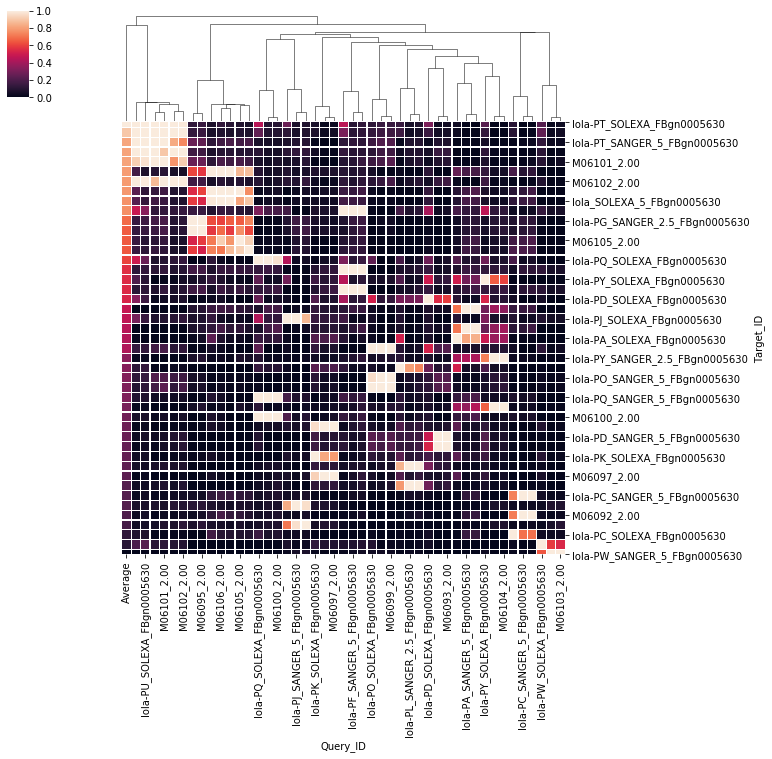

In [24]:
cg = sns.clustermap(tomtom_normalized, method='single', metric="euclidean", row_cluster=False, linewidths=.15, standard_scale=1)
cg
#test = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#test = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

### Run FISim analysis

In [1]:

import run_fisim

In [3]:
tf = "lola"
BASE_DIR = !pwd
BASE_DIR = BASE_DIR[0]
tf_name = tf
meme_in = '%s/Results/%s.meme' % (BASE_DIR, tf)
results_path = "%s/Results" % BASE_DIR
#Set figure to True to get it inline
run_fisim.run_fisim(tf_name, meme_in, results_path, figure=True)

FileNotFoundError: [Errno 2] File b'/home/festo/Documents/MARStool/MARS-Update-Pipeline/Evaluation/Results/lola.fisim' does not exist: b'/home/festo/Documents/MARStool/MARS-Update-Pipeline/Evaluation/Results/lola.fisim'

## Scoring and classification motif assessement and ranking

## Enrichment-Based Motif assessement and Ranking

In [1]:
tf = "lola"

In [2]:
import run_centrimo
tf_name = tf
meme_in = 'Results/%s.meme' % tf
#meme_in = 
results_path = "Results"

In [3]:
import glob
chip_list = glob.glob("/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/"+ tf + "/*")
chip_list

['/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/lola/ENCFF742LVH.posneg',
 '/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/lola/ENCFF603JQT.posneg',
 '/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/lola/ENCFF275OIZ.posneg',
 '/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/lola/ENCFF624NYK.posneg',
 '/home/festo/Documents/MARStool/MARS-Update-Pipeline/At100/dm/lola/ENCFF048PDV.posneg']

In [4]:
run_centrimo.run_centrimo(tf_name,chip_list,meme_in,results_path,figure=True)

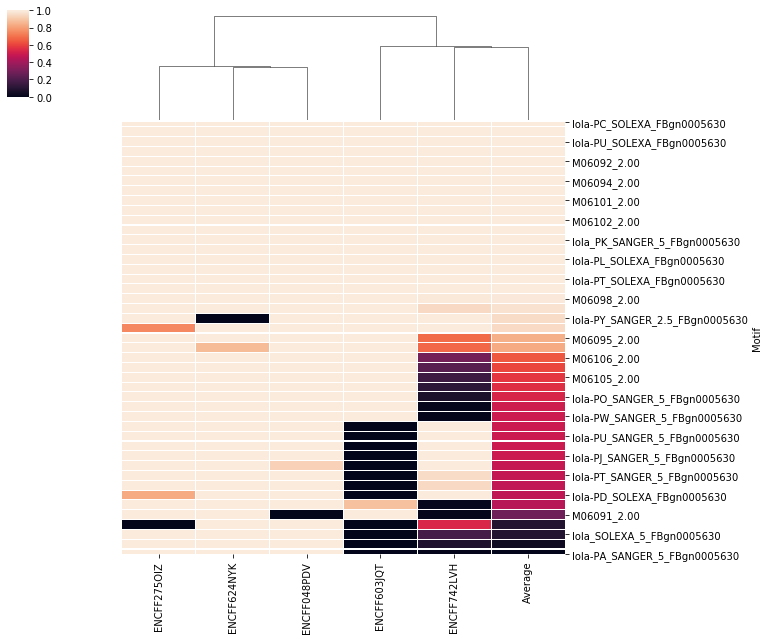

In [3]:
centrimo_in = 'Results/lola_centrimo_norm.txt'
centrimo_table = pd.read_table(centrimo_in, index_col=0)
centrimo_table.sort_values(by="Average", axis=0, ascending=False, inplace=True)

cg = sns.clustermap(centrimo_table, method='single', metric="euclidean",
                    row_cluster=False, linewidths=.15,standard_scale=1)
test = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
test = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

In [1]:
import os
import sys
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils import tab2fasta, mkdir_p, meme_path, BASE_DIR



centrimo_df = pd.read_table('Results/lola_centrimo.txt', index_col=0, sep= "\t")
del centrimo_df['Average']
centrimo_df.head(10)

# centrimo_normalized = centrimo_df/centrimo_df.max()
# centrimo_normalized = centrimo_normalized.replace(to_replace='NaN', value=0)
# average_column = centrimo_normalized.T.mean()
# average_column = average_column.to_frame(name="Average")

# # Add the average column to DataFramne
# centrimo_normalized = centrimo_normalized.T.append(average_column.T).T

# centrimo_normalized.sort_values(by="Average", axis=0, ascending=False, inplace=True)
# centrimo_normalized.to_csv('%s/%s_centrimo_norm.txt' % (files_path, tf_name), sep="\t")





,ENCFF742LVH,ENCFF603JQT,ENCFF275OIZ,ENCFF624NYK,ENCFF048PDV
Motif,,,,,
lola-PW_SOLEXA_FBgn0005630,-0.000002,0.00,-1.00,-1.0,-1.00
lola-PA_SANGER_5_FBgn0005630,-0.006100,0.00,-1.00,-1.0,-1.00
lola_SANGER_5_FBgn0005630,-0.084000,0.00,-1.00,-1.0,-1.00
lola_SOLEXA_5_FBgn0005630,-0.180000,0.00,-1.00,-1.0,-1.00
lola-PA_SOLEXA_FBgn0005630,-0.540000,0.00,-0.64,-1.0,-1.00
M06091_2.00,-0.008500,-1.00,-1.00,-1.0,-0.56
M06103_2.00,-0.014000,-0.89,-1.00,-1.0,-1.00
lola-PD_SOLEXA_FBgn0005630,-1.000000,0.00,-0.94,-1.0,-1.00
lola-PC_SANGER_5_FBgn0005630,-0.950000,0.00,-1.00,-1.0,-1.00


In [2]:
centrimo_df.max()

ENCFF742LVH   -0.000002
ENCFF603JQT    0.000000
ENCFF275OIZ   -0.640000
ENCFF624NYK   -0.920000
ENCFF048PDV   -0.560000
dtype: float64

In [3]:
centrimo_normalized = centrimo_df/centrimo_df.max()
centrimo_normalized = centrimo_normalized.replace([np.inf, -np.inf], np.nan)
centrimo_normalized = centrimo_normalized.replace(np.nan, value=0)
centrimo_normalized.head(10)

,ENCFF742LVH,ENCFF603JQT,ENCFF275OIZ,ENCFF624NYK,ENCFF048PDV
Motif,,,,,
lola-PW_SOLEXA_FBgn0005630,1.000000,0.0,1.56250,1.086957,1.785714
lola-PA_SANGER_5_FBgn0005630,4066.666667,0.0,1.56250,1.086957,1.785714
lola_SANGER_5_FBgn0005630,56000.000000,0.0,1.56250,1.086957,1.785714
lola_SOLEXA_5_FBgn0005630,120000.000000,0.0,1.56250,1.086957,1.785714
lola-PA_SOLEXA_FBgn0005630,360000.000000,0.0,1.00000,1.086957,1.785714
M06091_2.00,5666.666667,0.0,1.56250,1.086957,1.000000
M06103_2.00,9333.333333,0.0,1.56250,1.086957,1.785714
lola-PD_SOLEXA_FBgn0005630,666666.666667,0.0,1.46875,1.086957,1.785714
lola-PC_SANGER_5_FBgn0005630,633333.333333,0.0,1.56250,1.086957,1.785714


In [4]:
average_column = centrimo_normalized.T.mean()
average_column = average_column.to_frame(name="Average")
average_column.head(10)

,Average
Motif,
lola-PW_SOLEXA_FBgn0005630,1.087034
lola-PA_SANGER_5_FBgn0005630,814.220367
lola_SANGER_5_FBgn0005630,11200.887034
lola_SOLEXA_5_FBgn0005630,24000.887034
lola-PA_SOLEXA_FBgn0005630,72000.774534
M06091_2.00,1134.063225
M06103_2.00,1867.553701
lola-PD_SOLEXA_FBgn0005630,133334.201617
lola-PC_SANGER_5_FBgn0005630,126667.553701


In [5]:
# Add the average column to DataFramne
centrimo_normalized = centrimo_normalized.T.append(average_column.T).T

centrimo_normalized.sort_values(by="Average", axis=0, ascending=False, inplace=True)
centrimo_normalized

,ENCFF742LVH,ENCFF603JQT,ENCFF275OIZ,ENCFF624NYK,ENCFF048PDV,Average
Motif,,,,,,
lola-PJ_SOLEXA_FBgn0005630,666666.666667,0.0,1.562500,1.086957,1.785714,133334.220367
lola-PY_SOLEXA_FBgn0005630,666666.666667,0.0,1.562500,1.086957,1.785714,133334.220367
lola-PC_SOLEXA_FBgn0005630,666666.666667,0.0,1.562500,1.086957,1.785714,133334.220367
lola-PD_SANGER_5_FBgn0005630,666666.666667,0.0,1.562500,1.086957,1.785714,133334.220367
M06092_2.00,666666.666667,0.0,1.562500,1.086957,1.785714,133334.220367
M06093_2.00,666666.666667,0.0,1.562500,1.086957,1.785714,133334.220367
M06094_2.00,666666.666667,0.0,1.562500,1.086957,1.785714,133334.220367
M06096_2.00,666666.666667,0.0,1.562500,1.086957,1.785714,133334.220367
M06097_2.00,666666.666667,0.0,1.562500,1.086957,1.785714,133334.220367


In [7]:
cg = sns.clustermap(centrimo_normalized, method='single', metric="euclidean",
                        row_cluster=False, linewidths=.15,standard_scale=1)
test = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
test = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

FloatingPointError: NaN dissimilarity value.